# DPD-Based Delinquency Curve and Vintage Analysis for Credit Risk Modeling

This notebook performs a vintage analysis of Lending Club loan data to compute and visualize Cumulative Default Rates (CDR) based on Days Past Due (DPD) statuses. The analysis includes data preprocessing, feature engineering, CDR calculation, and visualization using heatmaps.

- When loan risk peaks
- When the loan becomes stable
- If early delinquency is rising
- How underwriting changes impact loan quality

- Lending Club launch in mid 2007, there was very little data for 2007 vintage month. As peer to peer lending gained popularity, more loans were issued in 2008 and subsequent years.
- 2020 the company began its transition to a a digital bank after acquiring Radius Bank.
- 2021 Lending Club officially became a fully chartered U.S. bank, shifting its focus from peer-to-peer lending to traditional banking services.
- Today, Lending Club operates as a full service digital bank, offering a range of financial products including personal loans, savings accounts, and investment services.

### Load Libraries and Data

In [1]:
from logging import warning
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Load the dataset
chunk_size = 100000
chunks = pd.read_csv('accepted_2007_to_2018Q4.csv', chunksize = chunk_size)
loan_df = pd.concat(chunks, ignore_index = True)
print("Dataset loaded successfully.")

Dataset loaded successfully.


In [3]:
# Display the first few rows of the dataset
loan_df.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
0,68407277,NaN,3600.0,3600.0,3600.0,36 months,13.99,123.03,C,C4,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
1,68355089,NaN,24700.0,24700.0,24700.0,36 months,11.99,820.28,C,C1,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
2,68341763,NaN,20000.0,20000.0,20000.0,60 months,10.78,432.66,B,B4,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
3,66310712,NaN,35000.0,35000.0,35000.0,60 months,14.85,829.90,C,C5,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
4,68476807,NaN,10400.0,10400.0,10400.0,60 months,22.45,289.91,F,F1,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
loan_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2260701 entries, 0 to 2260700
Columns: 151 entries, id to settlement_term
dtypes: float64(113), object(38)
memory usage: 2.5+ GB


In [5]:
# Check for missing values
missing_values = loan_df.isnull().sum()
missing_values = missing_values[missing_values > 0].sort_values(ascending=False)
print("Missing values in each column:\n", missing_values)

Missing values in each column:
 member_id                                     2260701
orig_projected_additional_accrued_interest    2252050
hardship_dpd                                  2249784
hardship_status                               2249784
deferral_term                                 2249784
                                               ...   
out_prncp_inv                                      33
out_prncp                                          33
initial_list_status                                33
fico_range_high                                    33
revol_bal                                          33
Length: 150, dtype: int64


In [6]:
# Columns list
columns = loan_df.columns.tolist()
print("Dataset shape:", loan_df.shape)
print("Total number of columns:", len(columns))
print("Columns in the dataset:\n", *columns, sep=',\n')

Dataset shape: (2260701, 151)
Total number of columns: 151
Columns in the dataset:
,
id,
member_id,
loan_amnt,
funded_amnt,
funded_amnt_inv,
term,
int_rate,
installment,
grade,
sub_grade,
emp_title,
emp_length,
home_ownership,
annual_inc,
verification_status,
issue_d,
loan_status,
pymnt_plan,
url,
desc,
purpose,
title,
zip_code,
addr_state,
dti,
delinq_2yrs,
earliest_cr_line,
fico_range_low,
fico_range_high,
inq_last_6mths,
mths_since_last_delinq,
mths_since_last_record,
open_acc,
pub_rec,
revol_bal,
revol_util,
total_acc,
initial_list_status,
out_prncp,
out_prncp_inv,
total_pymnt,
total_pymnt_inv,
total_rec_prncp,
total_rec_int,
total_rec_late_fee,
recoveries,
collection_recovery_fee,
last_pymnt_d,
last_pymnt_amnt,
next_pymnt_d,
last_credit_pull_d,
last_fico_range_high,
last_fico_range_low,
collections_12_mths_ex_med,
mths_since_last_major_derog,
policy_code,
application_type,
annual_inc_joint,
dti_joint,
verification_status_joint,
acc_now_delinq,
tot_coll_amt,
tot_cur_bal,
open_acc_6

### Prepare the Data

In [7]:
# Vintage analysis dataframe, selecting relevant columns
vintage_df = loan_df[['id', 'loan_amnt', 'term', 'issue_d', 'last_pymnt_d', 'last_credit_pull_d', 'loan_status']].copy()
print("Vintage DataFrame created with shape:", vintage_df.shape)

Vintage DataFrame created with shape: (2260701, 7)


In [8]:
# Check for missing values
missing_values = vintage_df.isnull().sum()
print(missing_values[missing_values > 0])

loan_amnt               33
term                    33
issue_d                 33
last_pymnt_d          2460
last_credit_pull_d     105
loan_status             33
dtype: int64


In [9]:
# Value counts of loan_status
print(vintage_df['loan_status'].value_counts(dropna=False))

loan_status
Fully Paid                                             1076751
Current                                                 878317
Charged Off                                             268559
Late (31-120 days)                                       21467
In Grace Period                                           8436
Late (16-30 days)                                         4349
Does not meet the credit policy. Status:Fully Paid        1988
Does not meet the credit policy. Status:Charged Off        761
Default                                                     40
NaN                                                         33
Name: count, dtype: int64


In [10]:
# Check null values before cleaning
print("Missing values after cleaning:\n", vintage_df.isnull().sum())
print("Percentage of missing values:\n", (vintage_df.isnull().mean() * 100).round(2))

Missing values after cleaning:
 id                       0
loan_amnt               33
term                    33
issue_d                 33
last_pymnt_d          2460
last_credit_pull_d     105
loan_status             33
dtype: int64
Percentage of missing values:
 id                    0.00
loan_amnt             0.00
term                  0.00
issue_d               0.00
last_pymnt_d          0.11
last_credit_pull_d    0.00
loan_status           0.00
dtype: float64


In [11]:
# Drop null values in columns
vintage_df = vintage_df.dropna(subset=['loan_amnt', 'term', 'issue_d', 'loan_status'])
print("Missing values after cleaning:\n", vintage_df.isnull().sum())
print("Percentage of missing values after cleaning:\n", (vintage_df.isnull().mean() * 100).round(2))

Missing values after cleaning:
 id                       0
loan_amnt                0
term                     0
issue_d                  0
last_pymnt_d          2427
last_credit_pull_d      72
loan_status              0
dtype: int64
Percentage of missing values after cleaning:
 id                    0.00
loan_amnt             0.00
term                  0.00
issue_d               0.00
last_pymnt_d          0.11
last_credit_pull_d    0.00
loan_status           0.00
dtype: float64


In [12]:
# Does not meet credit policy statuses is not needed
no_needed_statuses = ['Does not meet the credit policy. Status:Fully Paid',
                      'Does not meet the credit policy. Status:Charged Off']
vintage_df = vintage_df[~vintage_df['loan_status'].isin(no_needed_statuses)]


In [13]:
# Feature engineering
# Convert date columns to datetime
vintage_df['issue_d'] = pd.to_datetime(vintage_df['issue_d'], errors='coerce', format='%b-%Y') # format='%b-%Y'
vintage_df['last_credit_pull_d'] = pd.to_datetime(vintage_df['last_credit_pull_d'], format='%b-%Y', errors='coerce')
vintage_df['last_pymnt_d'] = pd.to_datetime(vintage_df['last_pymnt_d'], errors='coerce', format='%b-%Y') # format='%b-%Y'
# Create vintage month column
vintage_df['vintage_month'] = vintage_df['issue_d'].dt.to_period('M')
# Define snapshot date as the latest last_credit_pull_d
snapshot_date = vintage_df['last_credit_pull_d'].dropna().max().to_period('M')
# Months on book (MOB)
vintage_df['MOB'] = (snapshot_date - vintage_df['issue_d'].dt.to_period('M')).apply(lambda x: x.n)
# Keep loans with MOB >= 0 and <= 60
vintage_df = vintage_df[(vintage_df['MOB'] >= 0) & (vintage_df['MOB'] <= 60)].copy()
# Year
vintage_df['issue_year'] = vintage_df['issue_d'].dt.year
# Print snapshot date
print("Snapshot date:", snapshot_date)
print("Vintage DataFrame after feature engineering shape:", vintage_df.shape)
vintage_df.head()


Snapshot date: 2019-04
Vintage DataFrame after feature engineering shape: (1982542, 10)


,id,loan_amnt,term,issue_d,last_pymnt_d,last_credit_pull_d,loan_status,vintage_month,MOB,issue_year
0,68407277,3600.0,36 months,2015-12-01,2019-01-01,2019-03-01,Fully Paid,2015-12,40,2015
1,68355089,24700.0,36 months,2015-12-01,2016-06-01,2019-03-01,Fully Paid,2015-12,40,2015
2,68341763,20000.0,60 months,2015-12-01,2017-06-01,2019-03-01,Fully Paid,2015-12,40,2015
3,66310712,35000.0,60 months,2015-12-01,2019-02-01,2019-03-01,Current,2015-12,40,2015
4,68476807,10400.0,60 months,2015-12-01,2016-07-01,2018-03-01,Fully Paid,2015-12,40,2015


### Convert loan_status to DPD categories (Days Past Due)

loan_status:

- Fully Paid: 0 DPD, good standing
- Current: 0 DPD, performing loan
- In Grace Period: 1-15 days DPD, early delinquency
- Late (16-30 days): 16-30 days DPD, moderate delinquency
- Late (31-120 days): 31-120 days DPD, serious delinquency
- Default: 121+ days DPD, defaulted loan (defaulted but not yet charged off - default bucket)
- Charged Off: 121+ days DPD, charged off loan (default bucket)

In [14]:
# Convert loan_status to DPD categories (Days Past Due)
vintage_df['flag_0'] = np.where(vintage_df['loan_status'].isin(['Fully Paid', 'Current']), 1, 0)
vintage_df['flag_15'] = np.where(vintage_df['loan_status'].isin(['In Grace Period']), 1, 0)
vintage_df['flag_30'] = np.where(vintage_df['loan_status'].isin(['Late (16-30 days)']), 1, 0)
vintage_df['flag_120'] = np.where(vintage_df['loan_status'].isin(['Late (31-120 days)']), 1, 0)
vintage_df['flag_120+'] = np.where(vintage_df['loan_status'].isin(['Default', 'Charged Off']), 1, 0)
vintage_df.head()

,id,loan_amnt,term,issue_d,last_pymnt_d,last_credit_pull_d,loan_status,vintage_month,MOB,issue_year,flag_0,flag_15,flag_30,flag_120,flag_120+
0,68407277,3600.0,36 months,2015-12-01,2019-01-01,2019-03-01,Fully Paid,2015-12,40,2015,1,0,0,0,0
1,68355089,24700.0,36 months,2015-12-01,2016-06-01,2019-03-01,Fully Paid,2015-12,40,2015,1,0,0,0,0
2,68341763,20000.0,60 months,2015-12-01,2017-06-01,2019-03-01,Fully Paid,2015-12,40,2015,1,0,0,0,0
3,66310712,35000.0,60 months,2015-12-01,2019-02-01,2019-03-01,Current,2015-12,40,2015,1,0,0,0,0
4,68476807,10400.0,60 months,2015-12-01,2016-07-01,2018-03-01,Fully Paid,2015-12,40,2015,1,0,0,0,0


### Build DPD Curves Vintage Analysis

In [15]:
dpd_0_vintage = (vintage_df.groupby('MOB')['flag_0'].mean() * 100).reset_index()
dpd_15_vintage = (vintage_df.groupby('MOB')['flag_15'].mean() * 100).reset_index()
dpd_30_vintage = (vintage_df.groupby('MOB')['flag_30'].mean() * 100).reset_index()
dpd_120_vintage = (vintage_df.groupby('MOB')['flag_120'].mean() * 100).reset_index()
dpd_120plus_vintage = (vintage_df.groupby('MOB')['flag_120+'].mean() * 100).reset_index()

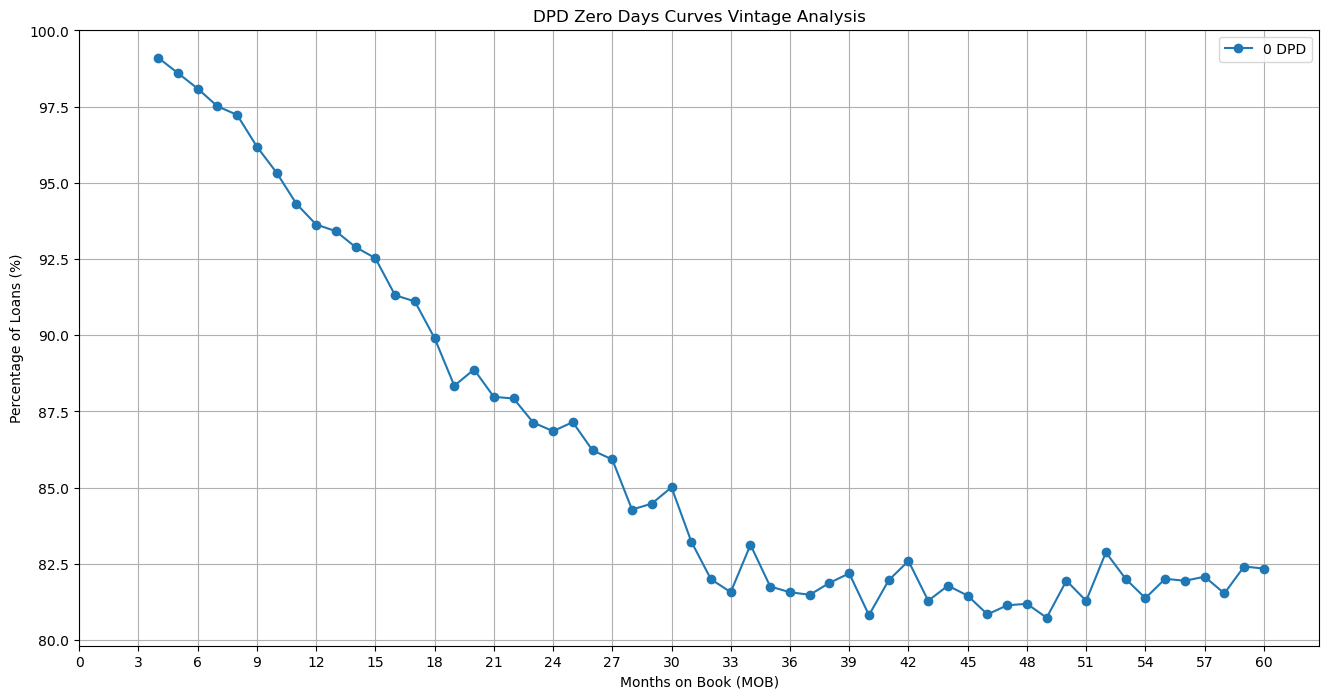

In [16]:
# Plot DPD 0 Vintage Curve
plt.figure(figsize=(16, 8))
plt.plot(dpd_0_vintage['MOB'], dpd_0_vintage['flag_0'], label='0 DPD', marker='o')
plt.title('DPD Zero Days Curves Vintage Analysis')
plt.xlabel('Months on Book (MOB)')
plt.ylabel('Percentage of Loans (%)')
plt.xticks(range(0, 61, 3))
plt.grid(True)
plt.legend()
plt.show()

DPD 0 Vintage Curve shows the percentage of loans that are in good stading starting from 99% at month 4 and gradually decreasing to around 80% to 82% at 33 months on book (MOB). This indicates that as loans age, a higher percentage of them experience some form of delinquency or default. Declines from 99% to 82%, this means about 18% of loans experience some level of delinquency by month 60. It is extremely realistic as loans age, the likelihood of delinquency increases.

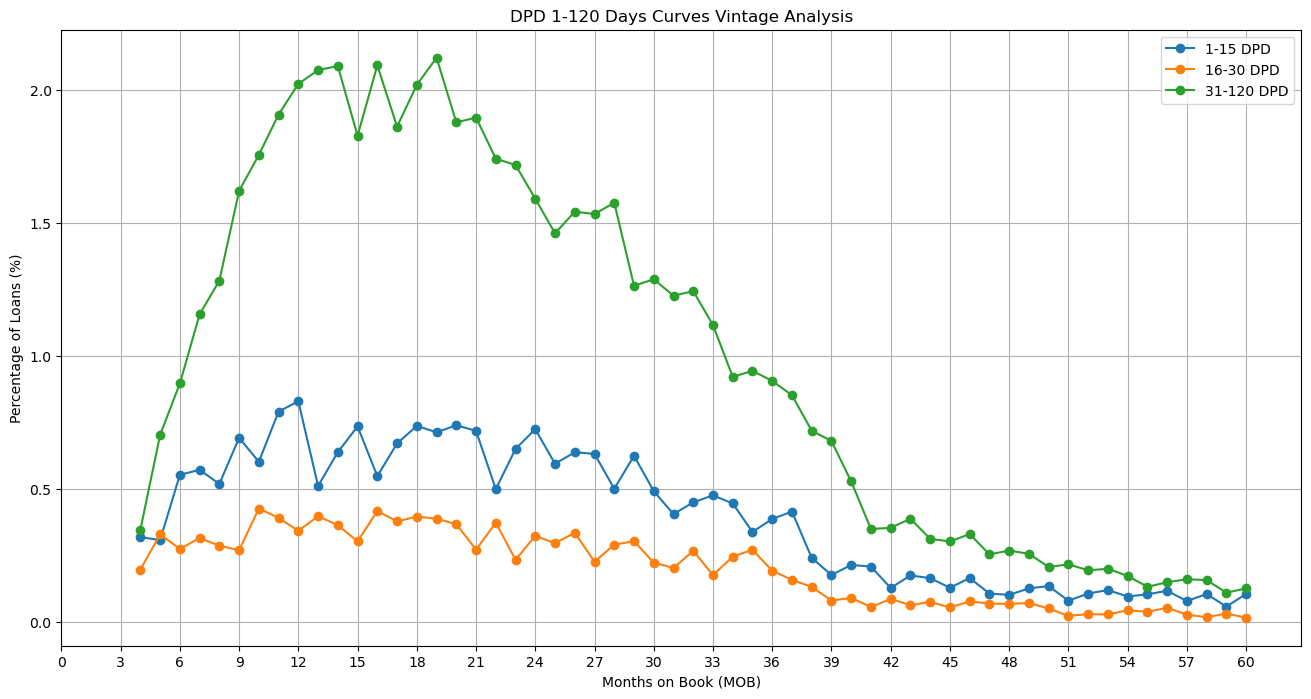

In [17]:
# Plot DPD Vintage Curves (1-120 DPD)
plt.figure(figsize=(16, 8))
plt.plot(dpd_15_vintage['MOB'], dpd_15_vintage['flag_15'], label='1-15 DPD', marker='o')
plt.plot(dpd_30_vintage['MOB'], dpd_30_vintage['flag_30'], label='16-30 DPD', marker='o')
plt.plot(dpd_120_vintage['MOB'], dpd_120_vintage['flag_120'], label='31-120 DPD', marker='o')
plt.title('DPD 1-120 Days Curves Vintage Analysis')
plt.xlabel('Months on Book (MOB)')
plt.ylabel('Percentage of Loans (%)')
plt.xticks(range(0, 61, 3))
plt.legend()
plt.grid(True)
plt.show()

- 1-15 DPD peaks early at around 0.8% at month 12, then gradually declines to around 0.1% at month 60. This is normal as early delinquencies are often resolved quickly.
- 16-30 DPD peaks at around 0.4% at month 15, then declines to near 0% by month 60. Shows portfolio stabilization.
- 31-120 DPD peaks at around 2.2% at month 19, then declines to around 0.2% by month 60. In early months near snapshot, serious delinquencies rise as some borrowers struggle to repay, but over time, many of these loans either recover or are charged off, leading to a decline in this category.

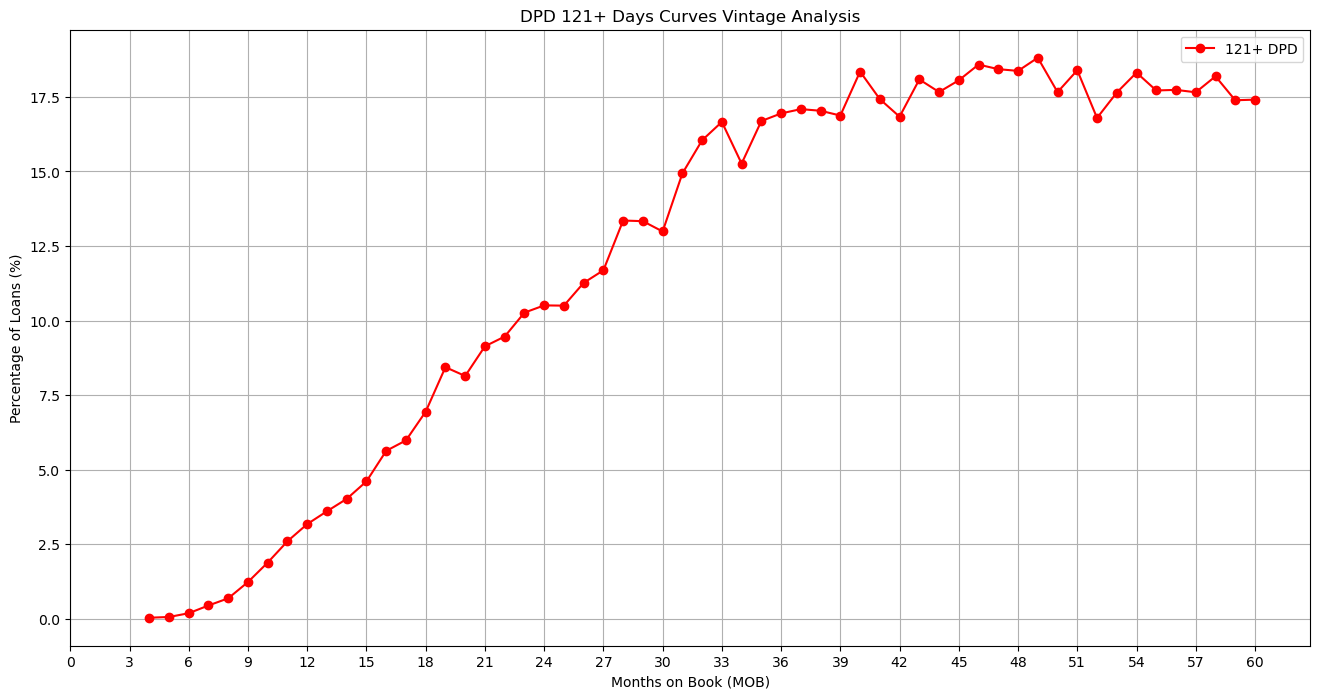

In [18]:
# Plot DPD 120+ Vintage Curve (defaulted loans)
plt.figure(figsize=(16, 8))
plt.plot(dpd_120plus_vintage['MOB'], dpd_120plus_vintage['flag_120+'], label='121+ DPD', marker='o', color='red')
plt.title('DPD 121+ Days Curves Vintage Analysis')
plt.xlabel('Months on Book (MOB)')
plt.ylabel('Percentage of Loans (%)')
plt.xticks(range(0, 61, 3))
plt.grid(True)
plt.legend()
plt.show()

DPD 121+ Vintage Curve shows the percentage of loans that have defaulted (121+ days past due) starting from 0% at month 4, peaks at around 18% at month 40,  and fluctuates to around 17% from month 40 to month 60. This indicates that as loans age, a higher percentage of them eventually default. The increase from 0% to 17% means that about 17% of loans default by month 60, which is a realistic trend in loan portfolios as some borrowers inevitably face financial difficulties over time.

In [19]:
# Year 2018
vintage_2018 = vintage_df[vintage_df['issue_year'] == 2018]
dpd_0_vintage_2018 = (vintage_2018.groupby('MOB')['flag_0'].mean() * 100).reset_index()
dpd_15_vintage_2018 = (vintage_2018.groupby('MOB')['flag_15'].mean() * 100).reset_index()
dpd_30_vintage_2018 = (vintage_2018.groupby('MOB')['flag_30'].mean() * 100).reset_index()
dpd_120_vintage_2018 = (vintage_2018.groupby('MOB')['flag_120'].mean() * 100).reset_index()
dpd_120plus_vintage_2018 = (vintage_2018.groupby('MOB')['flag_120+'].mean() * 100).reset_index()


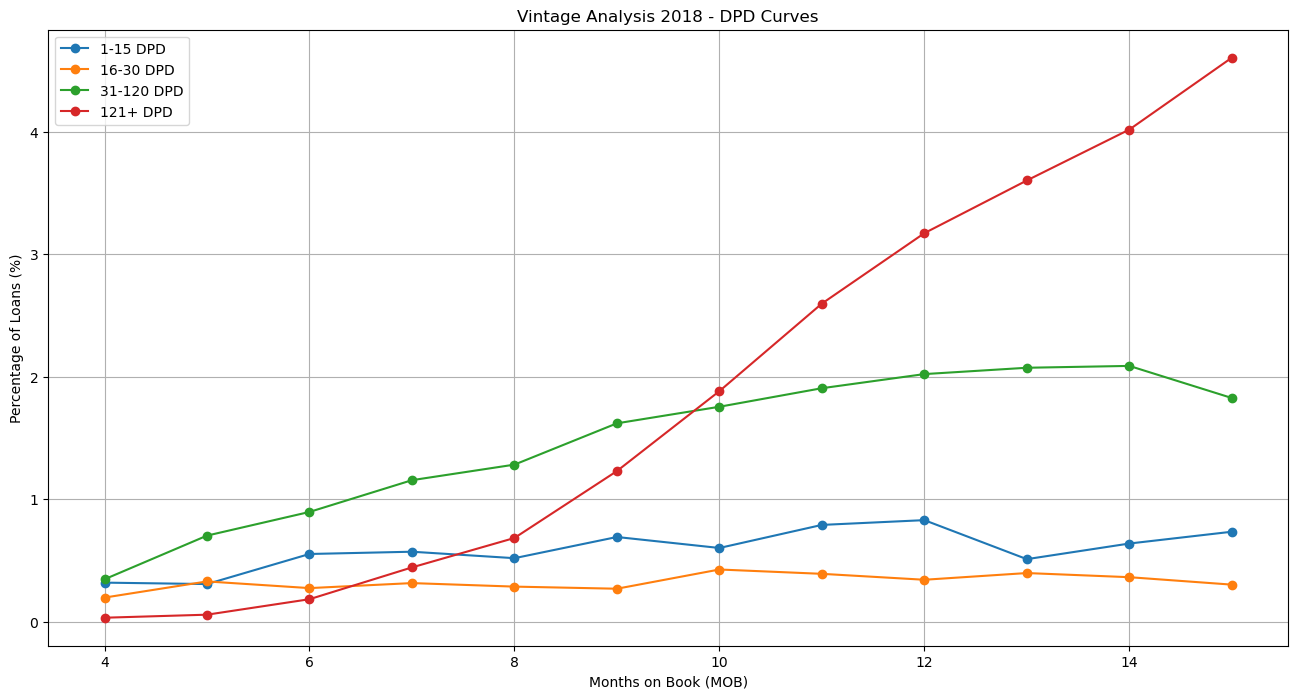

In [20]:
plt.figure(figsize=(16, 8))
#plt.plot(dpd_0_vintage_2018['MOB'], dpd_0_vintage_2018['flag_0'], label='0 DPD', marker='o')
plt.plot(dpd_15_vintage_2018['MOB'], dpd_15_vintage_2018['flag_15'], label='1-15 DPD', marker='o')
plt.plot(dpd_30_vintage_2018['MOB'], dpd_30_vintage_2018['flag_30'], label='16-30 DPD', marker='o')
plt.plot(dpd_120_vintage_2018['MOB'], dpd_120_vintage_2018['flag_120'], label='31-120 DPD', marker='o')
plt.plot(dpd_120plus_vintage_2018['MOB'], dpd_120plus_vintage_2018['flag_120+'], label='121+ DPD', marker='o')
plt.title('Vintage Analysis 2018 - DPD Curves')
plt.xlabel('Months on Book (MOB)')
plt.ylabel('Percentage of Loans (%)')
plt.legend()
plt.grid(True)
plt.show()

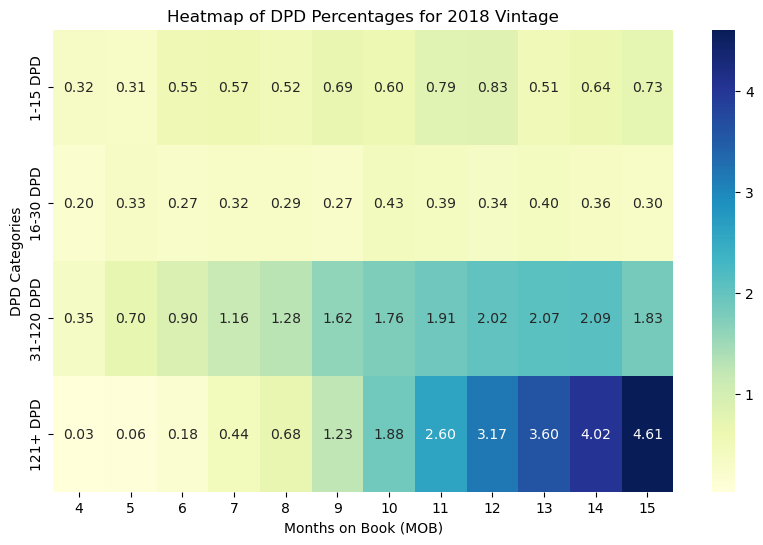

In [21]:
# Heatmap for year 2018 vintage DPDs
dpd_matrix_2018 = pd.DataFrame({
    'MOB': dpd_0_vintage_2018['MOB'],
    '1-15 DPD': dpd_15_vintage_2018['flag_15'],
    '16-30 DPD': dpd_30_vintage_2018['flag_30'],
    '31-120 DPD': dpd_120_vintage_2018['flag_120'],
    '121+ DPD': dpd_120plus_vintage_2018['flag_120+']
}).set_index('MOB')
plt.figure(figsize=(10, 6))
sns.heatmap(dpd_matrix_2018.T, annot=True, fmt=".2f", cmap="YlGnBu")
plt.title('Heatmap of DPD Percentages for 2018 Vintage')
plt.xlabel('Months on Book (MOB)')
plt.ylabel('DPD Categories')
plt.show()

- In early months of 1-15 DPD, Peak at month 12 around 0.8%, this is normal and not a strong indicator of rising delinquency.
- 16-30 DPD, the borrowers are not stuck in this bucket for long, this is common with marketplace loans.
- 31-120 DPD, peaks at month 13, 14 around 2%, indicating some borrowers struggle but many recover or are charged off. This is true risk signal loan past due over 30 days.
- 121 DPD, skyrockets at MOB 15 around 5%, this confirms the default window for Lending Club 2018 wintage is between MOB 9-15.

### Calculate Early Warning Indicators from Vintage Analysis

In [22]:
# DPD matrix
dpd_matrix = pd.DataFrame({
    'MOB': dpd_0_vintage['MOB'],
    '1-15 DPD': dpd_15_vintage['flag_15'],
    '16-30 DPD': dpd_30_vintage['flag_30'],
    '31-120 DPD': dpd_120_vintage['flag_120'],
    '121+ DPD': dpd_120plus_vintage['flag_120+']
}).set_index('MOB')


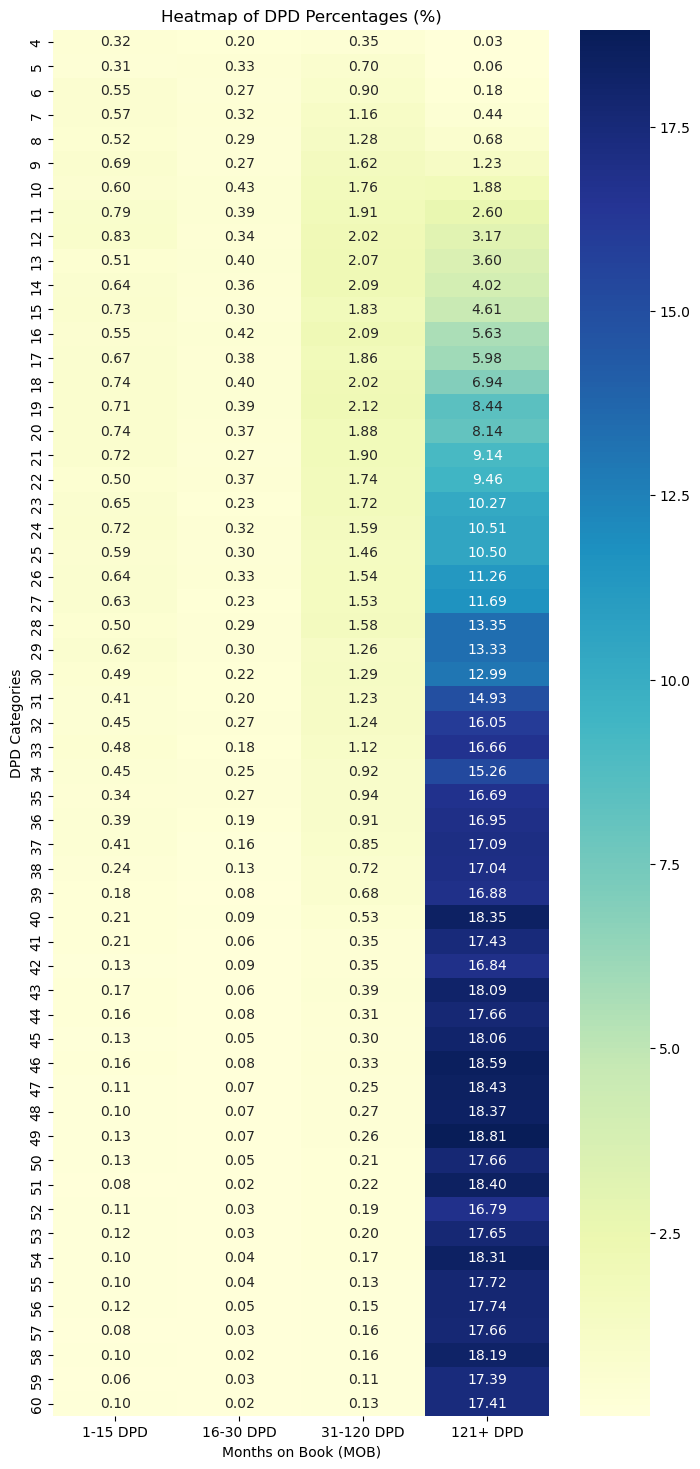

In [23]:
# DPD percentages heatmap
plt.figure(figsize=(8, 18))
sns.heatmap(dpd_matrix, annot=True, fmt=".2f", cmap="YlGnBu")
plt.title('Heatmap of DPD Percentages (%)')
plt.xlabel('Months on Book (MOB)')
plt.ylabel('DPD Categories')
plt.show()

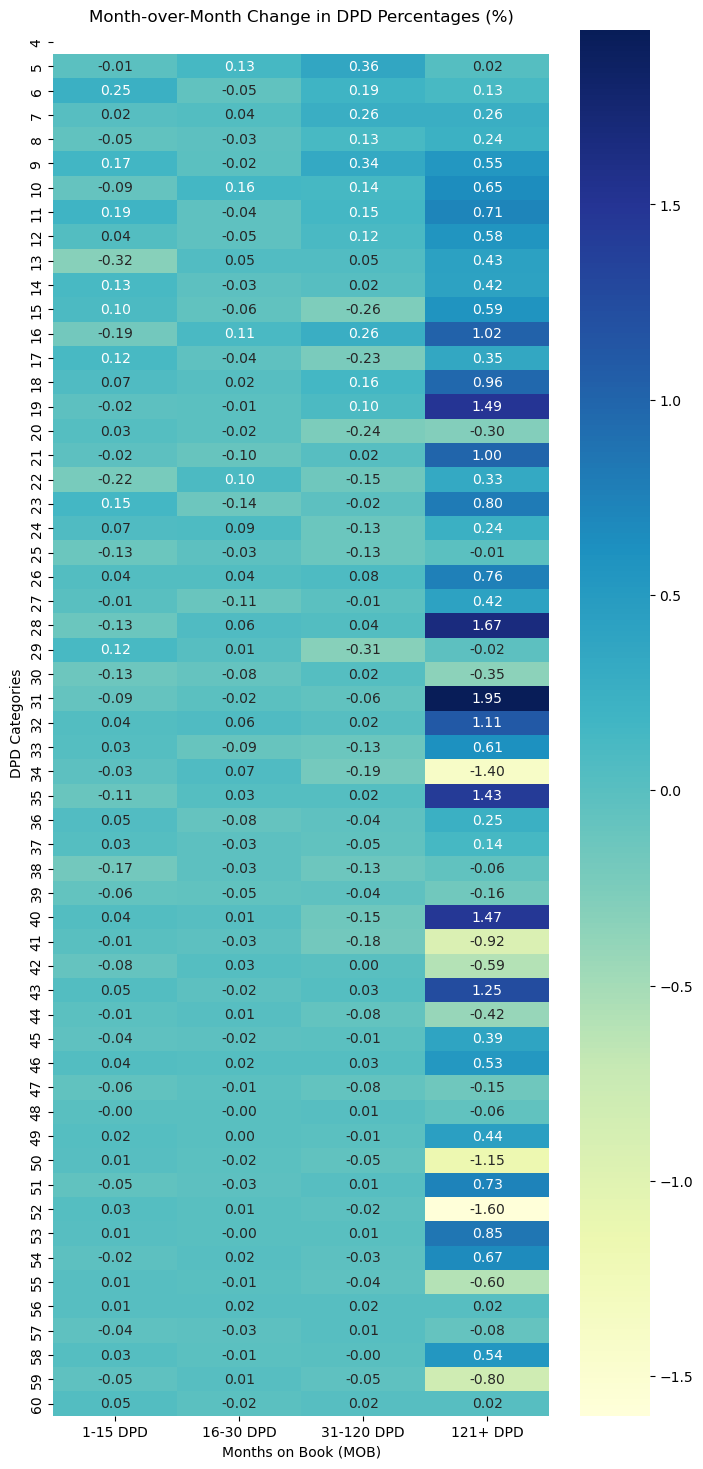

In [24]:
# Calculate month over month change in incidence
roll_rate = dpd_matrix.diff(1) #pct_change().fillna(0)
plt.figure(figsize=(8, 18))
sns.heatmap(roll_rate, annot=True, fmt=".2f", cmap="YlGnBu")
plt.title('Month-over-Month Change in DPD Percentages (%)')
plt.xlabel('Months on Book (MOB)')
plt.ylabel('DPD Categories')
plt.show()

Sine the dataset is a single snapshot one row per loan, we can only calculate month-over-month changes in DPD percentages as an approximation of roll rates.